<a href="https://colab.research.google.com/github/shiri9/Federated-Machine-Learning/blob/main/FL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q flwr[simulation] torch torchvision matplotlib;

In [3]:
from collections import OrderedDict
from typing import List, Tuple, Dict, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
#from torchvision.datasets import MNIST
from torch.utils.data import ConcatDataset, DataLoader, Dataset, Subset, random_split

import flwr as fl
from flwr.common import Metrics
from flwr.common.typing import NDArrays, Scalar

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 2.0.1+cu118 and Flower 1.5.0


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder,OneHotEncoder


#reading training csv file from google drive
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kdd_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kdd_test.csv')

#creating copies of datasets
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

#Encoding categories in 0-Normal, 1-DoS, 2-Probe, 3-R2L, 4-U2R
df1_train_labels = df_train_copy['labels']
df1_train_labels_in_numbers = df1_train_labels.replace({ 'normal' : 0, 'neptune' : 1,'land' : 1, 'back': 1, 'teardrop': 1, 'pod': 1, 'smurf' : 1,
                                                     'ipsweep' : 2, 'nmap' : 2, 'portsweep' : 2, 'satan' : 2,
                                                     'phf': 3, 'multihop': 3, 'warezclient': 3,'warezmaster': 3, 'spy': 3, 'ftp_write' : 3,
                                                     'guess_passwd': 3,'imap': 3,
                                                     'buffer_overflow': 4, 'loadmodule': 4,'perl': 4,  'rootkit': 4 })
#replacing the string output clsses by numbers
df_train_copy['labels'] = df1_train_labels_in_numbers

#Encoding categories in 0-Normal, 1-DoS, 2-Probe, 3-R2L, 4-U2R
df1_test_labels = df_test_copy['labels']
df1_test_labels_in_numbers = df1_test_labels.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1,
                                                      'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1,
                                                     'ipsweep' : 2, 'nmap' : 2, 'portsweep' : 2, 'satan' : 2, 'mscan' : 2,'saint' : 2,
                                                     'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3, 'warezclient': 3,
                                                       'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,
                                                       'xsnoop': 3,'httptunnel': 3,
                                                     'buffer_overflow': 4, 'loadmodule': 4,'perl': 4,  'rootkit': 4, 'ps': 4,'xterm': 4 })
#replacing the string output clsses by numbers
df_test_copy['labels'] = df1_test_labels_in_numbers

#Transform categorical features into numbers using LabelEncoder() from train dataset
dft = df_train_copy.apply(LabelEncoder().fit_transform)
df_train_copy = dft

#Transform categorical features into numbers using LabelEncoder() from test dataset
dftt = df_test_copy.apply(LabelEncoder().fit_transform)
df_test_copy = dftt

# Dropping the column "num_outbound_cmds" from train and test datasets
df_train_copy = df_train_copy.drop('num_outbound_cmds', axis=1)
df_test_copy = df_test_copy.drop('num_outbound_cmds', axis=1)

from sklearn.preprocessing import MinMaxScaler

# Select the columns to be normalized (assuming they are numerical features)
numerical_columns = ['duration', 'service', 'flag', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate',
                     'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
                     'dst_host_same_src_port_rate','dst_host_serror_rate', 'dst_host_srv_serror_rate', 'rerror_rate',
                     'srv_rerror_rate','diff_srv_rate', 'srv_diff_host_rate', 'dst_host_srv_diff_host_rate',
                     'dst_host_rerror_rate', 'dst_host_srv_rerror_rate','hot','num_compromised','num_root',]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the selected columns
scaler.fit(df_train_copy[numerical_columns])

# Transform the selected columns with the scaler
df_train_copy[numerical_columns] = scaler.transform(df_train_copy[numerical_columns])

# Select the columns to be normalized (assuming they are numerical features)
numerical_columns = ['duration', 'service', 'flag', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate',
                     'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
                     'dst_host_same_src_port_rate','dst_host_serror_rate', 'dst_host_srv_serror_rate', 'rerror_rate',
                     'srv_rerror_rate','diff_srv_rate', 'srv_diff_host_rate', 'dst_host_srv_diff_host_rate',
                     'dst_host_rerror_rate', 'dst_host_srv_rerror_rate','hot','num_compromised','num_root',]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the selected columns
scaler.fit(df_test_copy[numerical_columns])

# Transform the selected columns with the scaler
df_test_copy[numerical_columns] = scaler.transform(df_test_copy[numerical_columns])

In [5]:
df_train_copy.shape

(125973, 41)

In [29]:
# Determine the number of partitions
num_partitions = 10

# Split your DataFrame into 10 partitions
partition_size = len(df_train_copy) // num_partitions
data_partitions = []

for i in range(num_partitions):
    start_index = i * partition_size
    end_index = (i + 1) * partition_size if i < num_partitions - 1 else len(df_train_copy)
    partition = df_train_copy.iloc[start_index:end_index]
    data_partitions.append(partition)

# Create DataLoaders for each partition with validation datasets
batch_size = 128  # Set your desired batch size
dataloaders = []
val_loaders = []

for partition in data_partitions:
    # Split each partition into training and validation subsets (90% train, 10% validation)
    len_partition = len(partition)
    len_train = int(0.9 * len_partition)
    len_val = len_partition - len_train

    train_partition, val_partition = random_split(partition, [len_train, len_val], generator=torch.Generator().manual_seed(42))

    # Prepare training DataLoader
    train_features = train_partition.dataset.drop(columns=['labels'])  # Replace 'labels' with your label column name
    train_labels = train_partition.dataset['labels']  # Replace 'labels' with your label column name

    train_features_tensor = torch.Tensor(train_features.values)
    train_labels_tensor = torch.Tensor(train_labels.values)

    train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    # Prepare validation DataLoader
    val_features = val_partition.dataset.drop(columns=['labels'])  # Replace 'labels' with your label column name
    val_labels = val_partition.dataset['labels']  # Replace 'labels' with your label column name

    val_features_tensor = torch.Tensor(val_features.values)
    val_labels_tensor = torch.Tensor(val_labels.values)

    val_dataset = TensorDataset(val_features_tensor, val_labels_tensor)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    dataloaders.append(train_dataloader)
    val_loaders.append(val_dataloader)

# Create a DataLoader for the test dataset
test_features = df_test_copy.drop(columns=['labels'])  # Replace 'labels' with your label column name
test_labels = df_test_copy['labels']  # Replace 'labels' with your label column name

test_features_tensor = torch.Tensor(test_features.values)
test_labels_tensor = torch.Tensor(test_labels.values)

test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Now 'dataloaders' is a list of training DataLoaders, 'val_loaders' is a list of validation DataLoaders,
# and 'test_dataloader' is the DataLoader for the test dataset.
# Each partition has its own training and validation DataLoader.
# You can use these for federated learning, and validation during training, and testing.


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define your layers here
        self.fc1 = nn.Linear(40, 128)  # 40 input features, 128 hidden units
        self.fc2 = nn.Linear(128, 64)  # 128 hidden units, 64 hidden units
        self.fc3 = nn.Linear(64, 5)   # 64 hidden units, 5 output classes (assuming you have 5 classes)

    def forward(self, x):
        # Define the forward pass
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [21]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    lrate = 0.01
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lrate)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for data, labels in trainloader:
            data, labels = data.to(DEVICE), labels.long().to(DEVICE)
            optimizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()
            total += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
        epoch_loss /= len(trainloader)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for data, labels in testloader:
            data, labels = data.to(DEVICE), labels.long().to(DEVICE)
            outputs = net(data)
            loss += criterion(outputs, labels).item()
            total += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader)
    accuracy = correct / total
    return loss, accuracy

In [30]:
net = Net().to(DEVICE)
num_clients = 10

for epoch in range(20):
    print(f"Training for epoch {epoch+1}")
    for i in range(num_clients):
        dataloader = dataloaders[i]
        valloader = val_loaders[i]
        train(net, dataloader, 1)
        loss, accuracy = test(net, valloader)
        print(f"Client {i+1} Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

    print(f"End of epoch {epoch+1}")

# After all epochs, test the model with the testloader
loss, accuracy = test(net, test_dataloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")


Training for epoch 1
Client 1 Epoch 1: validation loss 0.07197998853569681, accuracy 0.9734063665952211
Client 2 Epoch 1: validation loss 0.038594644907109364, accuracy 0.9845201238390093
Client 3 Epoch 1: validation loss 0.03349316992204298, accuracy 0.9861871874255775
Client 4 Epoch 1: validation loss 0.03652330564871205, accuracy 0.9874573311105819
Client 5 Epoch 1: validation loss 0.024012647397496333, accuracy 0.9922997539096611
Client 6 Epoch 1: validation loss 0.029046062591739676, accuracy 0.9910296102246566
Client 7 Epoch 1: validation loss 0.02712796719255622, accuracy 0.9903151544018417
Client 8 Epoch 1: validation loss 0.028106861823059694, accuracy 0.9892037786774629
Client 9 Epoch 1: validation loss 0.020888135246956024, accuracy 0.9919822179884099
Client 10 Epoch 1: validation loss 0.033310117802084094, accuracy 0.9900793650793651
End of epoch 1
Training for epoch 2
Client 1 Epoch 2: validation loss 0.023250897412630495, accuracy 0.991267762165595
Client 2 Epoch 2: valid

In [11]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [12]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [13]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = dataloaders[int(cid)]
    valloader = val_loaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

In [31]:
NUM_CLIENTS = 10

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=20),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-09-21 10:57:52,359 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-09-21 10:58:04,529	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-09-21 10:58:11,298 | app.py:210 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7851159552.0, 'object_store_memory': 3925579776.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7851159552.0, 'object_store_memory': 3925579776.0}
INFO flwr 2023-09-21 10:58:11,308 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-09-21 10:58:11,314 | app.py:224 | Flower VCE: Resources for each Virtual Cl

History (loss, distributed):
	round 1: 0.06279505155604295
	round 2: 0.03653736748553888
	round 3: 0.034471543021311966
	round 4: 0.030965313973432086
	round 5: 0.03270738724656779
	round 6: 0.026871390652965114
	round 7: 0.025588199767669795
	round 8: 0.028449355971745468
	round 9: 0.022535771244167904
	round 10: 0.02162590793997162
	round 11: 0.02564211450376068
	round 12: 0.022412144328288808
	round 13: 0.02659404751670669
	round 14: 0.02230302387521593
	round 15: 0.025356072523499452
	round 16: 0.018786183204925196
	round 17: 0.024882393875253397
	round 18: 0.016514332190442904
	round 19: 0.0287178111081529
	round 20: 0.025735065360986298

In [15]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [32]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=20),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-09-21 11:03:24,375 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-09-21 11:03:29,805	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-09-21 11:03:32,831 | app.py:210 | Flower VCE: Ray initialized with resources: {'memory': 7849387623.0, 'object_store_memory': 3924693811.0, 'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7849387623.0, 'object_store_memory': 3924693811.0, 'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO flwr 2023-09-21 11:03:32,835 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-09-21 11:03:32,842 | app.py:224 | Flower VCE: Resources for each Virtual Cl

History (loss, distributed):
	round 1: 0.05919684876753676
	round 2: 0.036743540243443215
	round 3: 0.03329770276511107
	round 4: 0.032402512727474624
	round 5: 0.028448626551908825
	round 6: 0.026618136738831497
	round 7: 0.026520187918077965
	round 8: 0.02551644314409732
	round 9: 0.026699604468438963
	round 10: 0.025852553472581384
	round 11: 0.02415092952568272
	round 12: 0.021369617863445343
	round 13: 0.02111572407684618
	round 14: 0.020849096880181495
	round 15: 0.01903689453787537
	round 16: 0.019154391469048203
	round 17: 0.020477820135361393
	round 18: 0.026197056744407598
	round 19: 0.025222829365020974
	round 20: 0.027300394938393223
History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.9815987933634992), (2, 0.9878224974200206), (3, 0.9885375089306978), (4, 0.9899182345002777), (5, 0.9909978566325316), (6, 0.9912518853695325), (7, 0.9918552036199095), (8, 0.9922044931332857), (9, 0.9915856723256103), (10, 0.9926807970151624), (11, 0.9939987903393476), (12, 0.994363

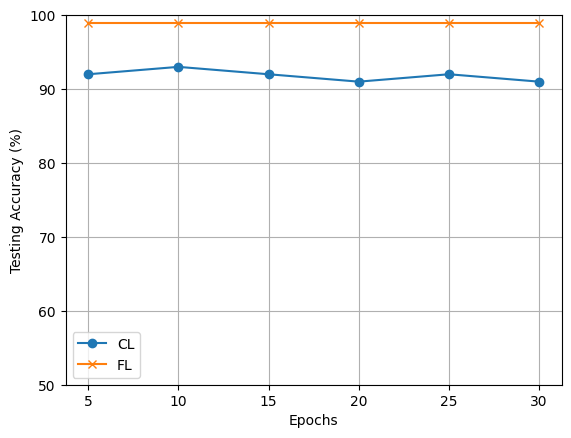

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
epochs = [5, 10, 15, 20, 25, 30]
cl_accuracy = [92, 93, 92, 91, 92, 91]
fl_accuracy = [99, 99, 99, 99, 99, 99]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot CL accuracy with lines and markers at epoch points
ax.plot(epochs, cl_accuracy, marker='o', linestyle='-', label='CL')

# Plot FL accuracy with lines and markers at epoch points
ax.plot(epochs, fl_accuracy, marker='x', linestyle='-', label='FL')

# Set labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Testing Accuracy (%)')
ax.grid(True)

# Add a legend
ax.legend()

# Set y-axis limits between 50 and 100
ax.set_ylim(50, 100)

# Set x-axis ticks to only display specified epoch values
ax.set_xticks(epochs)

# Save the plot as a PNG image
plt.savefig('acc_vs_epochs.png')

#


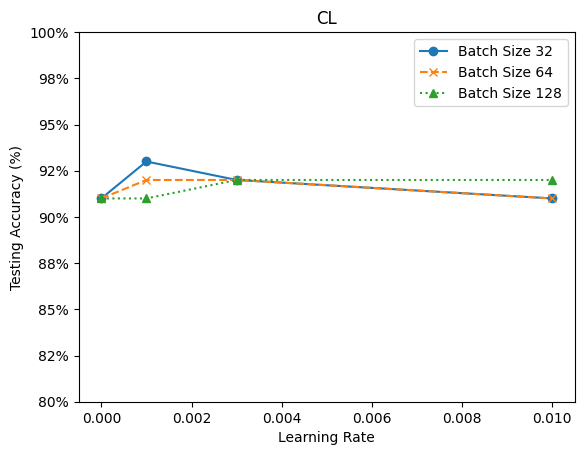

In [64]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Data
selected_learning_rates = [0, 0.001, 0.003, 0.01]
batch_sizes = [32, 64, 128]

cl_accuracy = {
    32: [0.91, 0.93, 0.92, 0.91],
    64: [0.91, 0.92, 0.92, 0.91],
    128: [0.91, 0.91, 0.92, 0.92]
}

# Create a figure and axis
fig, ax = plt.subplots()

# Set the line styles and markers for each batch size
line_styles = ['-', '--', ':']
markers = ['o', 'x', '^']

# Plot CL accuracy for each batch size
for batch_size in batch_sizes:
    cl_accuracies = [cl_accuracy[batch_size][selected_learning_rates.index(lr)] * 100 for lr in selected_learning_rates]  # Convert to percentage
    ax.plot(selected_learning_rates, cl_accuracies, linestyle=line_styles[batch_sizes.index(batch_size)], marker=markers[batch_sizes.index(batch_size)], label=f'Batch Size {batch_size}')

# Set labels and title
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Testing Accuracy (%)')
ax.set_title('CL')
ax.legend()

# Set y-axis limits between 90% and 100%
ax.set_ylim(80, 100)

# Format y-axis tick labels as percentages
def percentage_formatter(x, pos):
    return f'{x:.0f}%'

ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

# Save the plot as a PNG image
plt.savefig('CL-batch_lear.png')

# Show the plot
plt.show()


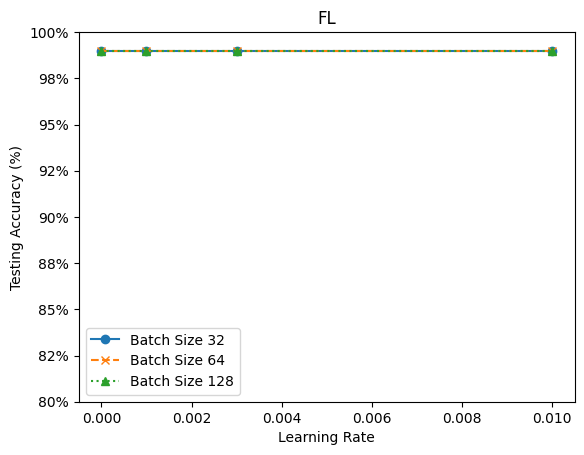

In [72]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Data
selected_learning_rates = [0, 0.001, 0.003, 0.01]
batch_sizes = [32, 64, 128]

fl_accuracy = {
    32: [0.99, 0.99, 0.99, 0.99],
    64: [0.99, 0.99, 0.99, 0.99],
    128: [0.99, 0.99, 0.99, 0.99]
}

# Create a figure and axis
fig, ax = plt.subplots()

# Set the line styles and markers for each batch size
line_styles = ['-', '--', ':']
markers = ['o', 'x', '^']

# Plot CL accuracy for each batch size
for batch_size in batch_sizes:
    fl_accuracies = [fl_accuracy[batch_size][selected_learning_rates.index(lr)] * 100 for lr in selected_learning_rates]  # Convert to percentage
    ax.plot(selected_learning_rates, fl_accuracies, linestyle=line_styles[batch_sizes.index(batch_size)], marker=markers[batch_sizes.index(batch_size)], label=f'Batch Size {batch_size}')

# Set labels and title
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Testing Accuracy (%)')
ax.set_title('FL')
ax.legend()

# Set y-axis limits between 90% and 100%
ax.set_ylim(80, 100)

# Format y-axis tick labels as percentages
def percentage_formatter(x, pos):
    return f'{x:.0f}%'

ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

# Save the plot as a PNG image
plt.savefig('FL-batch_lear.png')

# Show the plot
plt.show()



In [73]:
from google.colab import files

# Download the plot
files.download('FL-batch_lear.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>